In [1]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.model_selection import KFold
from multiprocessing import Process, Manager, SimpleQueue
import multiprocessing
import shutil
import sys
import time
from sklearn.metrics import accuracy_score
from rules import *
from vote_CST import *
from cv import *
from precision_CST_new import *
from amie import *

root = "./../../Tree_Constant_GT/"
cv = 3

colors_to_print = ["red",  "blue", "orange",  "violet", "darkgrey", "darkred", "darkblue", "darkorange", "darkviolet", "grey"]

limit_tree = 0.7

# 1° Load data

In [2]:
data = pd.read_csv("./../Data/miniloan-decisions-100K.csv")

In [3]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# Ratios

In [4]:
ratio_names = [("income","yearlyReimbursement"), ("income","loanAmount"), ("loanAmount","rate")]

In [5]:
# Takes two features and will create the ratio f_0/f_1
def create_features_ratio(data):
    if data[data.index[1]] == 0:
        return 2147483647
    return np.round(data[data.index[0]]/data[data.index[1]], decimals=2)

In [6]:
for ratio_name in ratio_names:
    data[f"{ratio_name[0]}/{ratio_name[1]}"] = data[[ratio_name[0], ratio_name[1]]].apply(create_features_ratio, axis=1)

In [7]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate
0,John Doe,736,113243,783440,162,0.030005,false,70648,1.60,0.14,26110372.80
1,John Doe,527,224186,1787385,183,0.054819,false,173197,1.29,0.13,32605003.59
2,John Doe,460,39954,1733494,75,0.055183,false,328563,0.12,0.02,31413368.70
3,John Doe,751,219998,1350004,72,0.043400,false,255970,0.86,0.16,31106073.81
4,John Doe,684,72470,1210944,160,0.037772,false,115742,0.63,0.06,32059172.14
...,...,...,...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928,0.48,0.05,31981153.44
99996,John Doe,395,184259,1599473,90,0.040564,false,247703,0.74,0.12,39430859.20
99997,John Doe,674,242620,1099790,260,0.040825,false,76557,3.17,0.22,26938940.88
99998,John Doe,420,180957,1645870,203,0.049558,false,143897,1.26,0.11,33211031.24


# 2° Find the best thresholds

In [8]:
data_raw = data.drop(columns=["name"])
false_data = data_raw[data_raw["approval"] == " false"]
true_data = data_raw[data_raw["approval"] == " true"]

nb_launch_tree = 10

In [9]:
%%time

def returnSplitValue(stringToSplit):
    res = []
    tp = ""
    spliters = [("lt", "< "), ("lte", "<= "), ("gt", "> "), ("gte", ">= ")]
    i=0
    
    while i < len(spliters):
        splited = stringToSplit.split(spliters[i][1]) 
        if len(splited) == 2:
            return  spliters[i][0], float(splited[1])
        i += 1
    print("C'est casse")
    return None 


best_threshold = []
for key in data.drop(columns=["name"]).columns:
    if key != "approval":
        res_accuracy_train = []
        res_accuracy_test = []
        model = None
        print("\t\t"+key)
        for i in range(nb_launch_tree):
            data_equilibrium = true_data.append(false_data.sample(n=len(true_data)))
            X = data_equilibrium[[key]]

            Y = data_equilibrium["approval"]

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

            model = tree.DecisionTreeClassifier(max_depth=1)
            model.fit(X_train, y_train)    
            
            res_accuracy_train.append(accuracy_score(y_train, model.predict(X_train)))
            res_accuracy_test.append(accuracy_score(y_test, model.predict(X_test)))
        print(f"Train Score : {np.mean(res_accuracy_train)}")
        print(f"Test Score : {np.mean(res_accuracy_test)}")

        if np.mean(res_accuracy_train) > limit_tree and np.mean(res_accuracy_test) > limit_tree:
            best_threshold.append((key,)+ returnSplitValue(tree.export_text(model, spacing=1, feature_names=[key]).split("\n")[0]))
print(best_threshold)

		creditScore
Train Score : 0.5043408797334965
Test Score : 0.4990338164251208
		income
Train Score : 0.6463967638860562
Test Score : 0.6440579710144927
		loanAmount
Train Score : 0.8443503977156844
Test Score : 0.8419323671497585
		monthDuration
Train Score : 0.6088381263172207
Test Score : 0.6076949620427882
		rate
Train Score : 0.5100686654429261
Test Score : 0.5061007591442374
		yearlyReimbursement
Train Score : 0.8994731117003196
Test Score : 0.8987025534851621
		income/yearlyReimbursement
Train Score : 0.9932014412944457
Test Score : 0.993022774327122
		income/loanAmount
Train Score : 0.9227819702223128
Test Score : 0.9235265700483092
		loanAmount/rate
Train Score : 0.8269528859881705
Test Score : 0.8260662525879917
[('loanAmount', 'lte', 839479.5), ('yearlyReimbursement', 'lte', 64975.5), ('income/yearlyReimbursement', 'lte', 3.33), ('income/loanAmount', 'lte', 0.24), ('loanAmount/rate', 'lte', 17722312.0)]
CPU times: user 8.61 s, sys: 15.6 ms, total: 8.62 s
Wall time: 8.62 s


# 3° Create the thresholds

Define the thresholds

In [10]:
def GTE_prep_df(value, valueToCompareTo):
    return value >= valueToCompareTo

def LTE_prep_df(value, valueToCompareTo):
    return value <= valueToCompareTo

def GT_prep_df(value, valueToCompareTo):
    return value > valueToCompareTo

def LT_prep_df(value, valueToCompareTo):
    return value < valueToCompareTo

In [11]:
columns = list(data.drop(columns=["name", "approval"]).columns)

booleanDF = pd.DataFrame()

for column, comparator, value in best_threshold:
    if comparator == "lte" or comparator == "gt":
        booleanDF[column+"-GT-"+str(value)] = data[column].map(lambda x : GT_prep_df(x, value))
#         booleanDF[column+"-LTE-"+str(value)] = data[column].map(lambda x : LTE_prep_df(x, value))
    else:
        booleanDF[column+"-GTE-"+str(value)] = data[column].map(lambda x : GTE_prep_df(x, value))
#         booleanDF[column+"-LT-"+str(value)] = data[column].map(lambda x : LT_prep_df(x, value))
    columns.remove(column)

In [12]:
booleanDF["approval"] = data["approval"].map({' true': True, ' false': False})
booleanDF

,loanAmount-GT-839479.5,yearlyReimbursement-GT-64975.5,income/yearlyReimbursement-GT-3.33,income/loanAmount-GT-0.24,loanAmount/rate-GT-17722312.0,approval
0,False,True,False,False,True,False
1,True,True,False,False,True,False
2,True,True,False,False,True,False
3,True,True,False,False,True,False
4,True,True,False,False,True,False
...,...,...,...,...,...,...
99995,True,True,False,False,True,False
99996,True,True,False,False,True,False
99997,True,True,False,False,True,False
99998,True,True,False,False,True,False


Create the folder where the data will be stored.

In [13]:
if not path.isdir(root):
    os.mkdir(root)
else : 
    shutil.rmtree(root)
    os.mkdir(root)

In [14]:
booleanDF.to_csv(root+"dfSave.csv")

# 4° Save the best data

In [15]:
# Transform an integer id to a string id
def int_to_str_id(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

# Syntax of Amie data
def syntax(subject, predicate, objectD):
    return f"{subject}\t{predicate}\t{objectD} \n" # Integer id
    #return f"{int_to_str_id(subject)}\t{predicate}\t{objectD} \n" #String id

# Create the text for each feature and finally write it to the file
def formatData(f, idData, data):
    toWrite = ""
    for i in data.index:
        toWrite += syntax(idData, i, data.loc[i])
    f.write(toWrite)

We store the data in the Amie format. 

In [16]:
f = open(root+"Knowledge_Data.tsv", "w")

booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

for idData in booleanDF_to_Save.index:
    formatData(f, idData, booleanDF_to_Save.iloc[idData])
    
f.close()

## Save in cross validation

In [17]:
booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
kf.get_n_splits(booleanDF_to_Save)

cp = 0

for train_index, test_index in kf.split(booleanDF_to_Save):
    
    f = open(root+f"CV_train_{cp}.tsv", "w")

    for idData in train_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    print("Train repartition :\n",booleanDF_to_Save.iloc[train_index]["approval"].value_counts())
    
    f = open(root+f"CV_valid_{cp}.tsv", "w")

    for idData in test_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    f = open(root+f"index_{cp}.tsv", "w")

    f.write(str(train_index[0]))
    for i in range(1,len(train_index)):
        f.write(","+str(train_index[i]))
    f.write("\n")
    f.write(str(test_index[0]))
    for i in range(1,len(test_index)):
        f.write(","+str(test_index[i]))

    f.close()
    
    cp += 1

Train repartition :
 False    52004
True     14662
Name: approval, dtype: int64
Train repartition :
 False    52007
True     14660
Name: approval, dtype: int64
Train repartition :
 False    52081
True     14586
Name: approval, dtype: int64


# 5° Launch Amie

Describe the parameters.

In [2]:
atom_LIST = [2,3]
minc_LIST = [0, 0.4, 0.8]
minhc_LIST = [0, 0.4, 0.8]

Launch Amie.

In [3]:
%%time
# %%capture --no-stderr captured 

res_rules_raw = run_amie(atom_LIST, root, cv, True)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°6 : FinishedProcess n°7 : Launched

Process n°8 : Launched
Process n°9 : LaunchedProcess n°7 : FinishedProcess n°8 : FinishedProcess n°10 : Launched



Process n°11 : LaunchedProcess n°9 : FinishedProcess n°10 : Finished


Process n°11 : FinishedProcess n°12 : Launched

Process n°12 : Finished
Process n°0 : Finished
Process n°2 : Finished
Process n°4 : Finished
Process n°5 : Finished
Process n°1 : Finished
Process n°3 : Finished
CPU times: user 62.5 ms, sys: 438 ms, total: 500 ms
Wall time: 4h 14min 31s


Transform the raw output into sets of rules. 

In [4]:
rules_per_cv = parse_amie(res_rules_raw)

Retrieve the indexes for each CV.

In [5]:
indexes = retrieve_indexes(root, cv)
df = pd.read_csv(root+"dfSave.csv")

# 5° Precision

In [6]:
%%time

rules_per_para = run_precision(root, indexes, rules_per_cv)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : LaunchedProcess n°3 : Launched

Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°3 : Finished
Process n°7 : FinishedProcess n°9 : Finished

Process n°0 : Finished
Process n°11 : Finished
Process n°1 : Finished
Process n°5 : Finished
Process n°4 : Finished
Process n°2 : Finished
Process n°10 : Finished
Process n°8 : Finished
Process n°12 : Finished
Process n°6 : Finished
Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°1 : Finished
Process n°3 : Finished
Process n°7 : Finished
Process n°5 : Finished
Pr

Process Process-69:
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/precision_CST_new.py", line 33, in compute_precisions
    res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, variable=(not type(rule.conclusion.objectD) == type(False)), rule=rule).value_counts()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 185, in get_result
    return self.apply_standard()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, 

Process n°9 : Finished
Process n°3 : Finished
Process n°0 : Finished
Process n°10 : Finished
Process n°5 : Finished
Process n°7 : Finished
Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched


Process Process-78:
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/precision_CST_new.py", line 33, in compute_precisions
    res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, variable=(not type(rule.conclusion.objectD) == type(False)), rule=rule).value_counts()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 185, in get_result
    return self.apply_standard()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, 

Process n°9 : Finished
Process n°3 : Finished
Process n°0 : Finished
Process n°5 : Finished
Process n°10 : Finished
Process n°7 : Finished
Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched


Process Process-97:
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/precision_CST_new.py", line 33, in compute_precisions
    res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, variable=(not type(rule.conclusion.objectD) == type(False)), rule=rule).value_counts()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 185, in get_result
    return self.apply_standard()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, 

Process n°0 : Finished
Process n°9 : FinishedProcess n°3 : Finished



Process Process-90:
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/precision_CST_new.py", line 33, in compute_precisions
    res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, variable=(not type(rule.conclusion.objectD) == type(False)), rule=rule).value_counts()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 185, in get_result
    return self.apply_standard()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, 

Process n°5 : Finished
Process n°10 : Finished
Process n°7 : Finished
CPU times: user 266 ms, sys: 2.8 s, total: 3.06 s
Wall time: 2min 13s


### Add parameters

Describe the combinaison of these new parameters.

In [7]:
new_parameters = []
for minc in minc_LIST:
    for minhc in minhc_LIST:
        new_parameters.append([("stdConfidence", minc), ("headCoverage", minhc)])
print(new_parameters)

[[('stdConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0), ('headCoverage', 0.4)], [('stdConfidence', 0), ('headCoverage', 0.8)], [('stdConfidence', 0.4), ('headCoverage', 0)], [('stdConfidence', 0.4), ('headCoverage', 0.4)], [('stdConfidence', 0.4), ('headCoverage', 0.8)], [('stdConfidence', 0.8), ('headCoverage', 0)], [('stdConfidence', 0.8), ('headCoverage', 0.4)], [('stdConfidence', 0.8), ('headCoverage', 0.8)]]


Create the DataFrames corresponding to these parameters.

In [8]:
new_dfs = add_parameters(rules_per_para, new_parameters)

Print the precision for each parameters.

<AxesSubplot:>

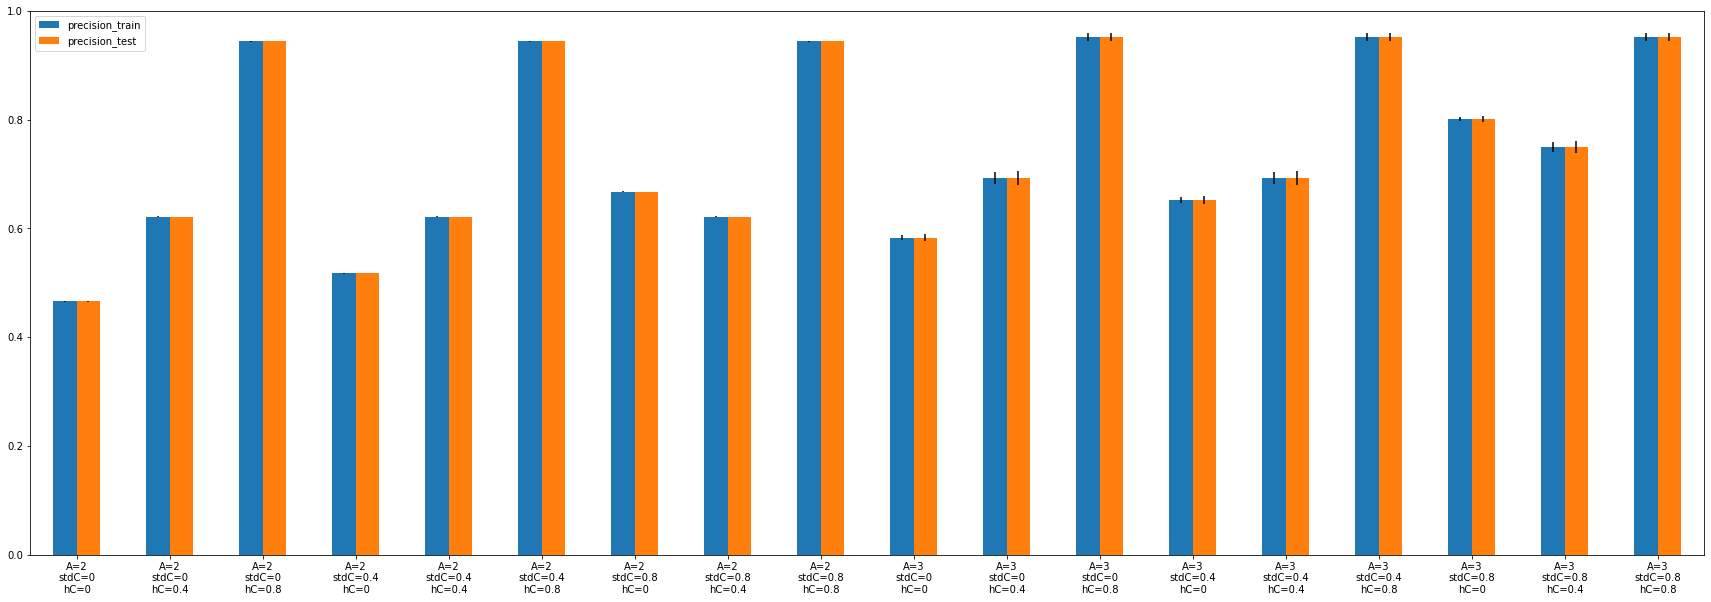

In [9]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 
to_print, to_print_std = mean_and_std_precision(new_dfs, cv)

to_print.plot.bar(ax=_axs, rot=0, yerr=to_print_std, ylim=[0,1])

# 6° Prediction

In [10]:
to_print_save =  []
to_print_std_save = []

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Value('d', 20)
Value('d', 30)
Value('d', 40)
Process n°0 : Finished
Process n°9 : Finished
Process n°3 : Finished
Process n°5 : Finished
Process n°6 : Finished
Process n°8 : Finished
Process n°12 : Finished
Process n°1 : Finished
Value('d', 50)
Process n°10 : Finished
Process n°11 : Finished
Process n°2 : Finished
Process n°4 : Finished
Process n°7 : Finished
54
CPU times: user 11.9 s, sys: 37.9 s, total: 49.8 s
Wall time: 8min 16s


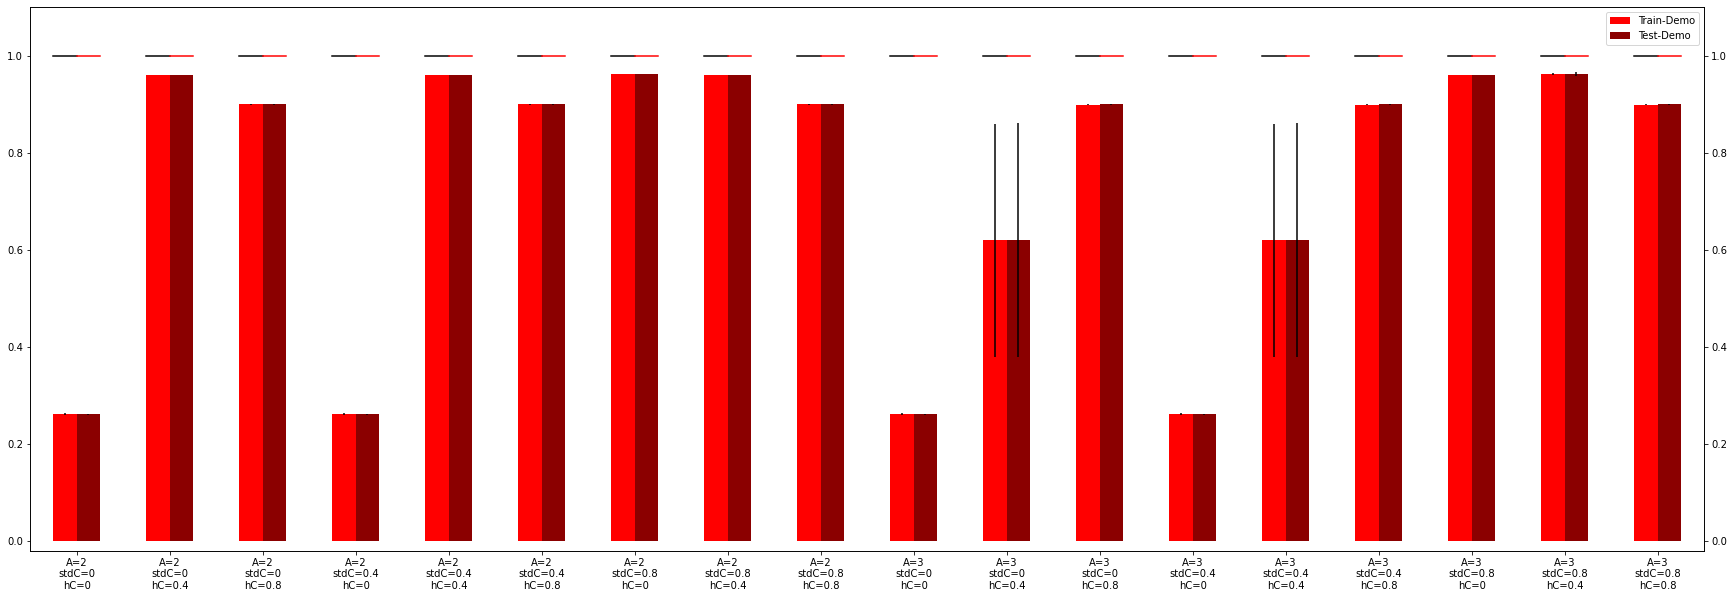

In [11]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy_proportional, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Demo")
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

max_possible = bestScorePossible(prediction_per_rules_count)
print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Value('d', 20)
Value('d', 30)
Value('d', 40)
Process n°4 : Finished
Process n°8 : Finished
Process n°9 : Finished
Process n°0 : Finished
Process n°12 : Finished
Process n°6 : Finished
Process n°5 : Finished
Process n°2 : Finished
Process n°3 : Finished
Value('d', 50)
Process n°1 : Finished
Process n°7 : Finished
Process n°10 : Finished
Process n°11 : Finished
54
CPU times: user 12 s, sys: 38.4 s, total: 50.4 s
Wall time: 1min 49s


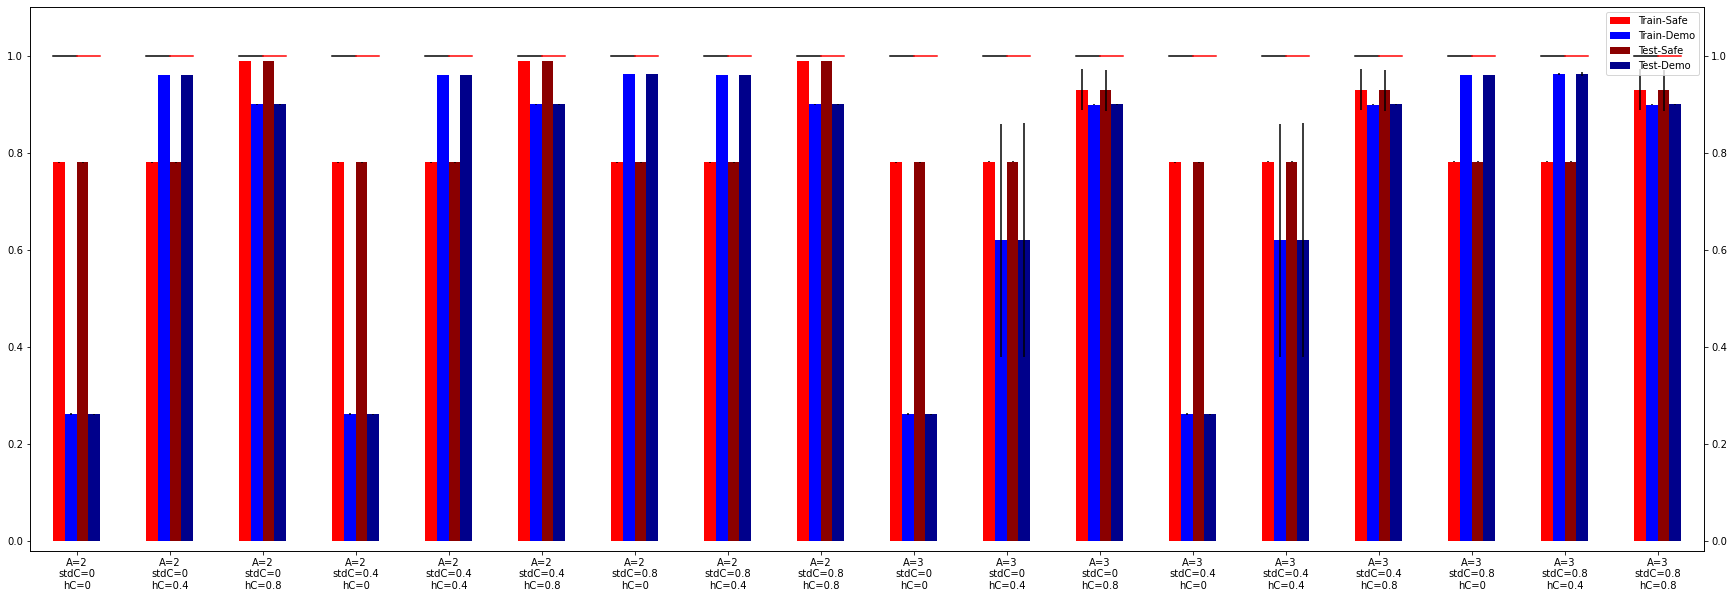

In [12]:
%%time

# prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, democracy, indexes, True)
prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, c, safe, indexes, True)

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "Safe")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

In [ ]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["precision_train", "precision_test"], [False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-precision")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Value('d', 20)


In [14]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["headCoverage", "precision_train", "precision_test"], [True, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-coverage")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched


Process Process-151:
Process Process-149:
Process Process-142:
Process Process-152:
Process Process-150:
Process Process-146:
Process Process-148:
Process Process-145:
Process Process-153:
Process Process-144:
Process Process-154:
Process Process-147:
Process Process-143:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
   

In [15]:
%%time

prediction_per_rules_count, prediction_per_rules_raw = prediction_test(root, cv, new_dfs, expert, indexes, True, ranking=(["size_hypothese", "precision_train", "precision_test"], [False, False, False]))

accuracy_prediction = compute_accuracy_prediction(prediction_per_rules_raw, df, indexes)

to_print, to_print_std = mean_and_std_vote(accuracy_prediction, "expert-length")
to_print, to_print_std = merge(to_print_save[-1], to_print, to_print_std_save[-1], to_print_std)
to_print_save.append(to_print)
to_print_std_save.append(to_print_std)

print_accuracy(to_print_save[-1], to_print_std_save[-1], max_possible, colors_to_print)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched

Process Process-156:
Exception ignored in: <function _releaseLock at 0x7f5a0fb8eca0>
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process Process-157:
Process Process-159:
Process Process-158:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


Process n°4 : Launched

  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 216, in paralel_prediction_res_baseline
    final_prediction_train = df.loc[train_index].apply(vote, rules_to_predict=rules_to_predict, axis=1)
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 216, in paralel_prediction_res_baseline
    final_prediction_train = df.loc[train_index].apply(vote, rules_to_predict=rules_to_predict, axis=1)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/proc

Process n°5 : Launched

  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, res_index = self.apply_series_generator()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 276, in apply_standard
    results, res_index = self.apply_series_generator()
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 187, in paralel_prediction_res_baseline
    print(f"Process n°{name} : Launched")
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 187, in paralel_prediction_res_baseline
    print(f"Process n°{name} : Launched")


  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 290, in apply_series_generator
    results[i] = self.f(v)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 290, in apply_series_generator
    results[i] = self.f(v)
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 410, in write
    self.pub_thread.schedule(self._flush)


Process n°6 : Launched

  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 410, in write
    self.pub_thread.schedule(self._flush)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 110, in f
    return func(x, *args, **kwds)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/apply.py", line 110, in f
    return func(x, *args, **kwds)
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 205, in schedule
    f()


  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 205, in schedule
    f()
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 75, in expert
    rule = rules_to_predict.iloc[cpt]
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 75, in expert
    rule = rules_to_predict.iloc[cpt]
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 381, in _flush
    self.session.send(self.pub_thread, 'stream', content=content,


Process n°7 : Launched

  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 381, in _flush
    self.session.send(self.pub_thread, 'stream', content=content,
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 895, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 895, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/fukoros/.local/lib/python3.8/site-packages/jupyter_client/session.py", line 753, in send
    stream.send_multipart(to_send, copy=copy)


  File "/home/fukoros/.local/lib/python3.8/site-packages/jupyter_client/session.py", line 753, in send
    stream.send_multipart(to_send, copy=copy)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 1486, in _getitem_axis
    if com.is_bool_indexer(key):
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 1503, in _getitem_axis
    return self.obj._ixs(key, axis=axis)
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 212, in send_multipart
    self.schedule(lambda : self._really_send(*args, **kwargs))


Process n°8 : Launched

  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 212, in send_multipart
    self.schedule(lambda : self._really_send(*args, **kwargs))
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/common.py", line 104, in is_bool_indexer
    is_array_like(key) and is_extension_array_dtype(key.dtype)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 2947, in _ixs
    new_values = self._mgr.fast_xs(i)
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 205, in schedule
    f()


  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 205, in schedule
    f()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/inference.py", line 214, in is_array_like
    return is_list_like(obj) and hasattr(obj, "dtype")
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/internals/managers.py", line 967, in fast_xs
    for i, rl in enumerate(blk.mgr_locs):
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 212, in <lambda>
    self.schedule(lambda : self._really_send(*args, **kwargs))
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 212, in <lambda>
    self.schedule(lambda : self._really_send(*args, **kwargs))
  File "pandas/_libs/lib.pyx", line 1033, in pandas._libs.lib.is_list_like


Process n°9 : Launched

  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py", line 267, in mgr_locs
    return self._mgr_locs
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 228, in _really_send
    ctx.term()
  File "/home/fukoros/.local/lib/python3.8/site-packages/ipykernel/iostream.py", line 228, in _really_send
    ctx.term()
  File "pandas/_libs/lib.pyx", line 1038, in pandas._libs.lib.c_is_list_like


KeyboardInterrupt
  File "/home/fukoros/.local/lib/python3.8/site-packages/zmq/sugar/context.py", line 165, in term
    return super(Context, self).term()
  File "/home/fukoros/.local/lib/python3.8/site-packages/zmq/sugar/context.py", line 165, in term
    return super(Context, self).term()
  File "/home/fukoros/anaconda3/lib/python3.8/abc.py", line 96, in __instancecheck__
    def __instancecheck__(cls, instance):


Process n°10 : Launched

  File "zmq/backend/cython/context.pyx", line 82, in zmq.backend.cython.context.Context.term
  File "zmq/backend/cython/context.pyx", line 82, in zmq.backend.cython.context.Context.term
KeyboardInterrupt


  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
Exception ignored in: <function _releaseLock at 0x7f5a0fb8eca0>
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Process n°11 : Launched

Process Process-164:
Process Process-165:
Process Process-161:
Process Process-160:
Process Process-163:
Process Process-162:
Process Process-166:
Process Process-167:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Trac

Process n°12 : Launched

  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 187, in paralel_prediction_res_baseline
    print(f"Process n°{name} : Launched")
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 216, in paralel_prediction_res_baseline
    final_prediction_train = df.loc[train_index].apply(vote, rules_to_predict=rules_to_predict, axis=1)
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py", line 5477, in __setattr__
    object.__getattribute__(self, name)
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/Thibaut/De

  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.get_result()
  File "/home/fukoros/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/series.py", line 536, in name
    return self._name
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 216, in paralel_prediction_res_baseline
    final_prediction_train = df.loc[train_index].apply(vote, rules_to_predict=rules_to_predict, axis=1)
  File "/mnt/c/Users/Thibaut/Desktop/FAC/M1 - DS/Stage/Stage/notebooks_mini_loans/vote_CST.py", line 216, in paralel_prediction_res_baseline
    final_prediction_train = df.loc[train_index].apply(vote, rules_to_predict=rules_to_predict, axis=1)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 7768, in apply
    return op.g

KeyboardInterrupt: 

  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 895, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py", line 1503, in _getitem_axis
    return self.obj._ixs(key, axis=axis)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 2951, in _ixs
    result = self._constructor_sliced(
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/series.py", line 364, in __init__
    data = sanitize_array(data, index, dtype, copy, raise_cast_failure=True)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/construction.py", line 461, in sanitize_array
    subarr = _try_cast(data, dtype, copy, raise_cast_failure)
  File "/home/fukoros/anaconda3/lib/python3.8/site-packages/pandas/core/construction.py", line 590, in _try_cast
    subarr = maybe_cast_to_datetime(arr, dtype)
  File "/hom

In [16]:
root

'./../../Tree_Constant_GT/'

In [ ]:
pd.DataFrame.to_csv()

In [19]:
for i in new_dfs:
    new_dfs[i].to_csv(root+"/Save/"+i+".tsv")